In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
from sklearn import preprocessing

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 
from helpers import metrics as mc
from helpers import infodynamics
from helpers.infodynamics import diachronic_correlations_lookback

import statsmodels.api as smapi
import statsmodels.graphics as smgraphics

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())


import warnings
warnings.filterwarnings("ignore")

# outliers kleuren, outlier detection zoeken, correlation degree/betweenness, LR, coefficienten afwijken.
# in paper
# per jaar om te kijken wat er gebeurt per kp
# betweenness wijst op politisering, liggen niet in community, op rand, specialisering zit in de concentratie van nodes
# outliers hebben politiserende werking

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]
labels_reverse =dict(zip(labels.values(),labels.keys()))

# Plot top betweenness and degree scores on scatter

In [14]:
annotations = {0: [40,90,98,7,97],
1: [80,16,60,32],
2: [80,0,59,9,66,1],
3: [16,59,9,2,77,1],
4: [80,0,2,59,9],
5: [80,20,58,9,59,32],
6: [80,39,58,32,59],
7: [74,16,58,6,82]}

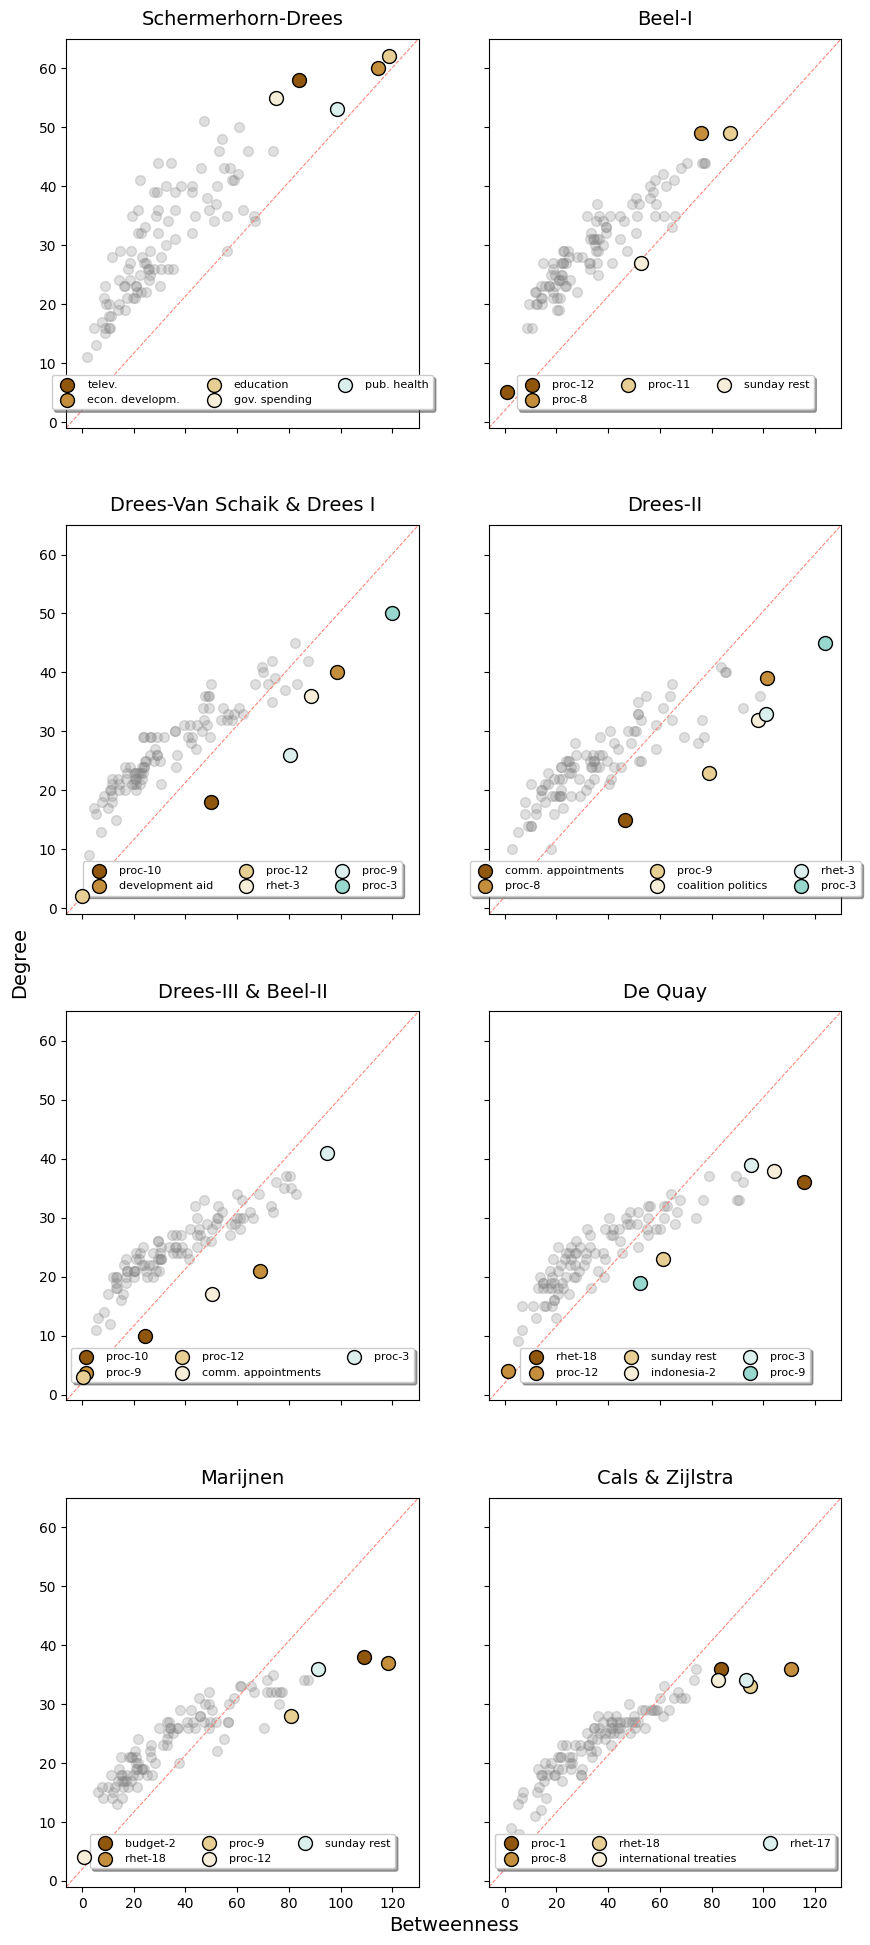

In [44]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

fig,axs = plt.subplots(4,2,figsize=(10,24),sharey=True,sharex=True)
axs = axs.flatten()

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)

    g,cmty,fmx = get_network_from_mi_theta(theta,weight_threshold=0)
    btw_vals_l = get_betweenness_values(g)
    deg_vals_l = get_degree_values(g)

    x = [i[1] for i in btw_vals_l]
    y = [i[1] for i in deg_vals_l]

    btw_vals = dict(btw_vals_l)
    deg_vals = dict(deg_vals_l)

    cmap = sns.color_palette('BrBG',8)
    c__ = 0
    for c_,topic in enumerate(deg_vals.keys()):
        lab = labels[topic].replace('economic development','econ. developm.').replace('television and broadcasters','television').replace('government','gov.').replace('committee','comm.').replace('television','telev.').replace('public','pub.')
        axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],
                        alpha=1 if topic in annotations[c] else .25,
                        label=lab if topic in annotations[c] else None,
                        color=cmap[c__] if topic in annotations[c] else 'grey',
                        s=100 if topic in annotations[c] else 50,
                        edgecolors='black' if topic in annotations[c] else None,
                        zorder=100 if topic in annotations[c] else 1)
        if topic in annotations[c]:
            c__ += 1
        # axs[c].annotate(xy=(btw_vals[topic],deg_vals[topic]),text=topic,alpha=.25,color=cmap[c_])

    axs[c].set_title(r['cabinet'],fontsize=14,pad=10)
    axs[c].legend(loc='upper center', bbox_to_anchor=(0.5, .15),ncol=3, fancybox=True, shadow=True,fontsize=8)

    line = mlines.Line2D([0, 1], [0, 1], color='salmon',linewidth=.75,linestyle='--')
    transform = axs[c].transAxes
    line.set_transform(transform)
    axs[c].add_line(line)   

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Betweenness",fontsize=14)
plt.ylabel("Degree",fontsize=14)
plt.subplots_adjust(hspace=.25)
plt.savefig('figs/networks-cabinets-betweenness-degree.pdf',dpi=250)
plt.show()
